### **Problem statement**

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindataframeul business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

* Which variables are significant in predicting the demand for shared bikes.
* How well those variables describe the bike demands


### **Reading & Understanding Data**

In [430]:
#importing required libraries & packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [431]:
#reading the data
dataframe = pd.read_csv('day.csv')
#checking the size of data
dataframe.shape

(730, 16)

In [432]:
#checking the information that is available on the data we have
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [433]:
#seeing the data we have
dataframe.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


##### **Observations:**
* The given dataset has 730 rows and 16 columns.
* The entire dataset is of either int64 or float64 datatype, except one column which is dteday.

### **Data Cleaning**

In [434]:
#dropping the columns that are not useful in our analysis or model building
dataframe.drop(['instant'],axis=1,inplace=True)              #instant refers to indexing which is not helpful
dataframe.drop(['dteday'],axis=1,inplace=True)               #dteday is redundant as we have yr,mnth,weekday seperately
dataframe.drop(['casual'],axis=1,inplace=True)               #casual is not helpful as it is part of count
dataframe.drop(['registered'],axis=1,inplace=True)           #registered is not helpful as it is part of count
#checking the data after removing the columns
dataframe.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [435]:
#checking for any null values present in the dataset
dataframe.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

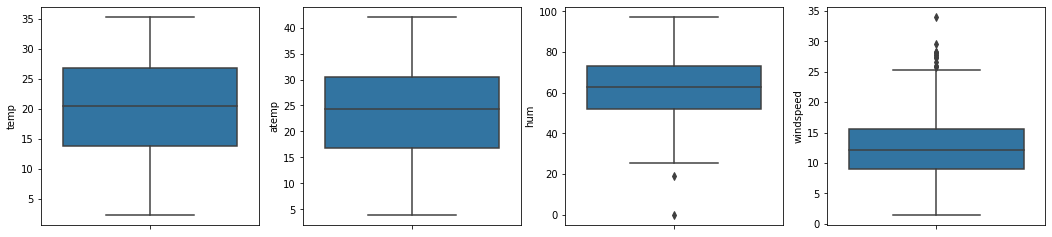

In [436]:
#checking for any outliers present in the data
cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=dataframe)
    i+=1

##### **Observations:**
* After dropping the unnecessary columns, the data we have is more reliable for model building.
* There are no null values in the dataset.
* There are no outliers in the dataset.

### **Performing EDA**

In [437]:
#converting categorical values to text values based on data dictionary provided
dataframe.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)
dataframe.weathersit.replace({1:'good',2:'moderate',3:'bad',4:'severe'},inplace = True)
dataframe.mnth = dataframe.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                                     7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})
dataframe.weekday = dataframe.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})
dataframe.yr = dataframe.yr.replace({0: '2018', 1:'2019'})
dataframe.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,mon,1,good,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,tue,1,good,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,wed,1,good,9.305237,11.46350,43.6957,12.522300,1600


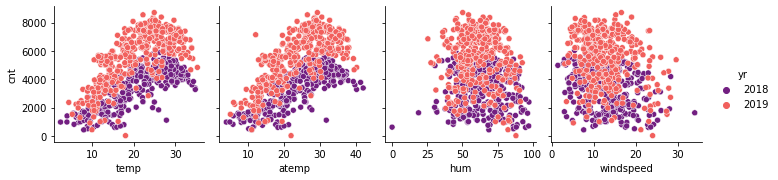

In [438]:
#checking linear relationship of cnt vs other numerical variables by drawing pairplots
sns.pairplot(dataframe, palette='magma', x_vars=['temp', 'atemp', 'hum', 'windspeed'], y_vars=['cnt'] , hue='yr' )
plt.show()

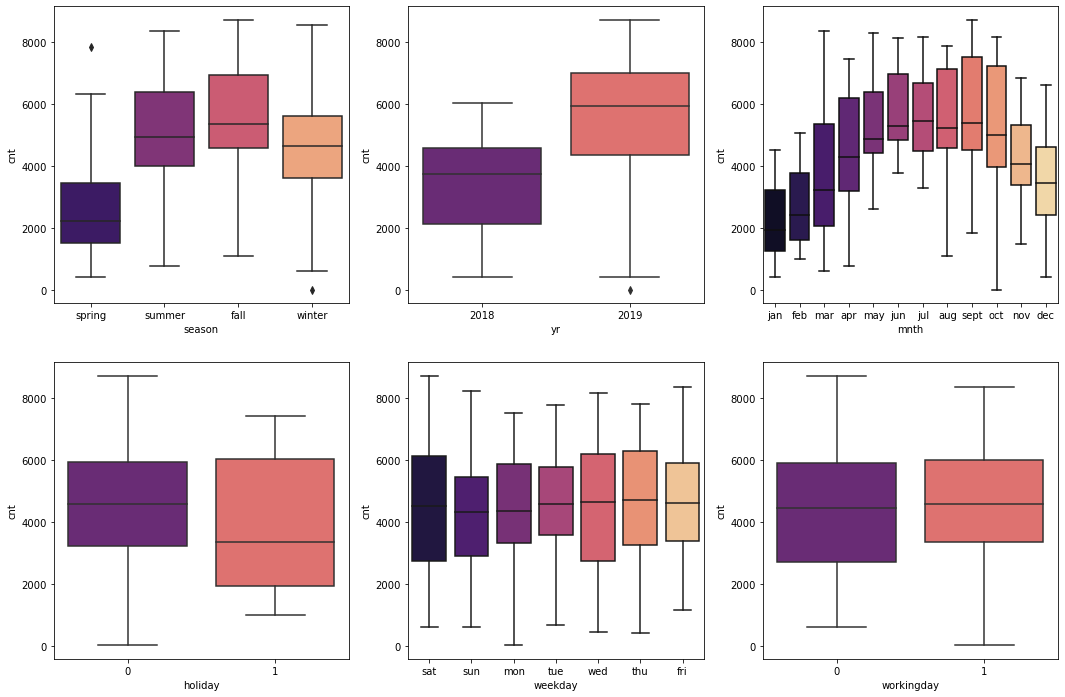

In [439]:
#checking the distribution of cnt vs other different categorical variables
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
sns.boxplot(x='season', y='cnt', data=dataframe, palette='magma')
plt.subplot(2,3,2)
sns.boxplot(x='yr', y='cnt', data=dataframe, palette='magma')
plt.subplot(2,3,3)
sns.boxplot(x='mnth', y='cnt', data=dataframe, palette='magma')
plt.subplot(2,3,4)
sns.boxplot(x='holiday', y='cnt', data=dataframe, palette='magma')
plt.subplot(2,3,5)
sns.boxplot(x='weekday', y='cnt', data=dataframe, palette='magma')
plt.subplot(2,3,6)
sns.boxplot(x='workingday', y='cnt', data=dataframe, palette='magma')

plt.show()

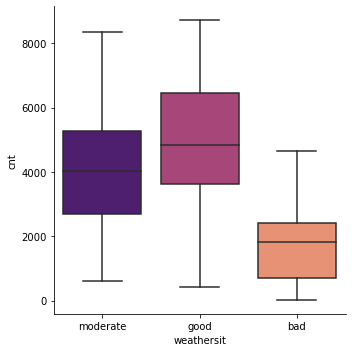

In [440]:
#checking the count of rentals alongside weather situtaion
sns.catplot(x='weathersit', y='cnt', data=dataframe, palette = "magma",  kind="box")
plt.show()


##### **Observations:**
From the above pairplot we can understand that:
* The season summer and fall are having higher counts compared to other two which indirectly shows there is correlation between temp and cnt.
* The company has performed well in 2019 compared to 2018 which means there are more number of rentals in 2019.
* As seasons are indirectly months we can see the same trend in the months plot.
* The count of rentals is high when weather situation is good or moderate where as low when weather situation is bad which mean customers often prefer good or atleast moderate weather while opting the service.

### **Data Preparation for Model Building**

In [441]:
#creating dummy variables for categorical variables
dataframe = pd.get_dummies(data=dataframe,columns=["season","mnth","weekday"],drop_first=True)
dataframe = pd.get_dummies(data=dataframe,columns=["weathersit"])
#checking the data after creating dummy variables
dataframe.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
0,2018,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,1
1,2018,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,1,0,0,0,0,0,1
2,2018,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,1,0,0,0,0,0,0,1,0
3,2018,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,1,0,0,1,0
4,2018,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,1,0,1,0


In [442]:
#splitting the dataframe into df_train, df_test with 70:30 ratio
df_train, df_test = train_test_split(dataframe, train_size=0.7, random_state=100)
#checking shape of both dataset
print(X_train.shape)
print(X_test.shape)

(510, 30)
(220, 30)


In [443]:
#ssing Normalized scaler to scale
scaler = MinMaxScaler()
cols = df_train.columns
df_train[cols] = scaler.fit_transform(df_train[cols])
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,...,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.625490,0.345098
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,...,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.484471,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


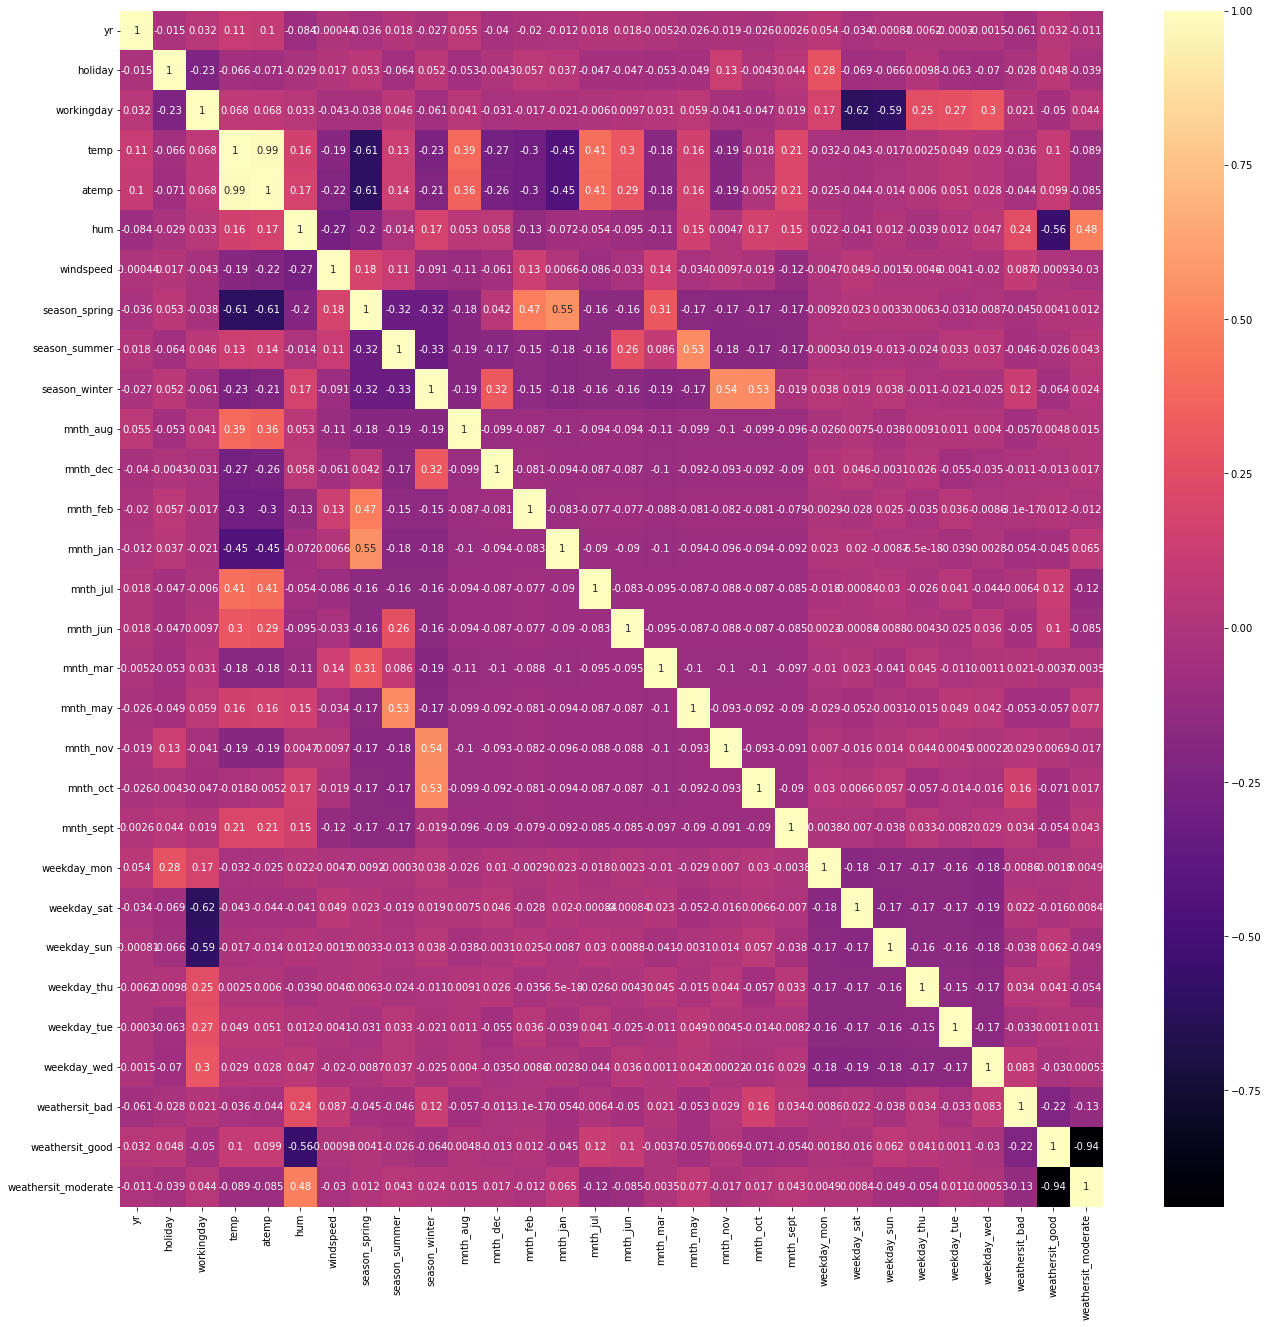

In [444]:
#checking collinearity using heatmap
plt.figure(figsize = (22, 22)) 
sns.heatmap(X_train.corr(), annot = True, cmap='magma')
plt.show()

##### **Observations:**
* Created dummy variables are pushed into dataframe.
* After splitting the dataset into 2 we have (511, 30) as train dataset and (219, 30) as test dataset.
* MinMax Scaler is succesfully applied to numerical variables.

##### **Note:**
* cnt is highly collinear with yr,tmp,atemp. 
* temp & atemp are pefectly collinear and are nearly same so while creating the model these variables should be considered carefully.


### **Model Building**

In [445]:
#considering all the columns for better results
y_train = df_train.pop('cnt')
X_train = df_train
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model1 = lr.fit()
lr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          2.81e-180
Time:                        11:48:25   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1259      0.030      4.254      0.000       0.068       0.184
yr                      0.2325      0.008     28.794      0.000       0.217       0.248
holiday                -0.0185      0.023     -0.789      0.431      -0.064       0.028
workingday              0.0669      0.011      5.865      0.000       0.044       0.089
temp                    0.3880      0.142      2.727      0.007       0.108       0.668
atemp                   0.0590      0.138      0.426      0.670      -0.213       0.331
hum                    -0.1520      0.039     -3.938      0.000      -0.228      -0.076
windspeed              -0.1836      0.026     -6.962      0.000      -0.235      -0.132
season_spring          -0.0454      0.030     -1.511      0.131      -0.104       0.014
season_summer           0.0424      0.026      1.617      0.107      -0.009       0.094
season_winter           0.1071      0.028      3.826      0.000       0.052       0.162
mnth_aug                0.0223      0.034      0.657      0.511      -0.044       0.089
mnth_dec               -0.0443      0.034     -1.316      0.189      -0.110       0.022
mnth_feb               -0.0323      0.033     -0.980      0.327      -0.097       0.032
mnth_jan               -0.0631      0.034     -1.876      0.061      -0.129       0.003
mnth_jul               -0.0327      0.035     -0.931      0.352      -0.102       0.036
mnth_jun                0.0060      0.025      0.241      0.810      -0.043       0.055
mnth_mar                0.0016      0.025      0.063      0.950      -0.047       0.050
mnth_may                0.0255      0.021      1.208      0.228      -0.016       0.067
mnth_nov               -0.0398      0.036     -1.093      0.275      -0.111       0.032
mnth_oct                0.0077      0.036      0.215      0.830      -0.063       0.078
mnth_sept               0.0868      0.032      2.711      0.007       0.024       0.150
weekday_mon            -0.0216      0.015     -1.401      0.162      -0.052       0.009
weekday_sat             0.0658      0.013      5.059      0.000       0.040       0.091
weekday_sun             0.0116      0.013      0.867      0.386      -0.015       0.038
weekday_thu            -0.0097      0.016     -0.623      0.534      -0.040       0.021
weekday_tue            -0.0184      0.016     -1.184      0.237      -0.049       0.012
weekday_wed            -0.0059      0.015     -0.394      0.694      -0.035       0.023
weathersit_bad         -0.1082      0.022     -4.965      0.000      -0.151      -0.065
weathersit_good         0.1468      0.012     12.747      0.000       0.124       0.169
weathersit_moderate     0.0873      0.013      6.807      0.000       0.062       0.112
==============================================================================
Omnibus:    

In [446]:
#checking Variance Inflation Factor 
#creating a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
29,weathersit_moderate,inf
1,holiday,inf
2,workingday,inf
28,weathersit_good,inf
27,weathersit_bad,inf
22,weekday_sat,inf
23,weekday_sun,inf
3,temp,66.90
4,atemp,56.03
7,season_spring,10.77


In [447]:
#removing all features with high VIF 
X = X_train.drop(['weathersit_moderate','holiday','workingday','weekday_sat',
                  'weekday_sun'],axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model2 = lr.fit()
lr_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     104.8
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          1.64e-177
Time:                        11:48:26   Log-Likelihood:                 512.87
No. Observations:                 510   AIC:                            -973.7
Df Residuals:                     484   BIC:                            -863.6
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2748      0.047      5.825      0.000       0.182       0.367
yr                  0.2325      0.008     28.112      0.000       0.216       0.249
temp                0.3774      0.145      2.608      0.009       0.093       0.662
atemp               0.0655      0.141      0.464      0.643      -0.212       0.343
hum                -0.1656      0.039     -4.204      0.000      -0.243      -0.088
windspeed          -0.1842      0.027     -6.823      0.000      -0.237      -0.131
season_spring      -0.0476      0.031     -1.547      0.123      -0.108       0.013
season_summer       0.0421      0.027      1.569      0.117      -0.011       0.095
season_winter       0.1124      0.029      3.925      0.000       0.056       0.169
mnth_aug            0.0291      0.035      0.839      0.402      -0.039       0.097
mnth_dec           -0.0455      0.034     -1.322      0.187      -0.113       0.022
mnth_feb           -0.0357      0.034     -1.059      0.290      -0.102       0.031
mnth_jan           -0.0627      0.034     -1.822      0.069      -0.130       0.005
mnth_jul           -0.0286      0.036     -0.796      0.426      -0.099       0.042
mnth_jun            0.0099      0.026      0.386      0.700      -0.040       0.060
mnth_mar            0.0066      0.025      0.263      0.793      -0.043       0.056
mnth_may            0.0286      0.022      1.321      0.187      -0.014       0.071
mnth_nov           -0.0525      0.037     -1.416      0.158      -0.125       0.020
mnth_oct            0.0011      0.037      0.029      0.977      -0.071       0.073
mnth_sept           0.0869      0.033      2.653      0.008       0.023       0.151
weekday_mon        -0.0130      0.012     -1.069      0.285      -0.037       0.011
weekday_thu         0.0074      0.013      0.575      0.566      -0.018       0.032
weekday_tue         0.0012      0.013      0.096      0.924      -0.024       0.026
weekday_wed         0.0135      0.012      1.130      0.259      -0.010       0.037
weathersit_bad     -0.1916      0.026     -7.465      0.000      -0.242      -0.141
weathersit_good     0.0536      0.011      5.050      0.000       0.033       0.075
==============================================================================
Omnibus:                       84.627   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.327
Skew:                          -0.802   Prob(JB):                     1.77e-52
Kurtosis:                       5.940   Cond. No.                         87.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [448]:
#checking Variance Inflation Factor 
#creating a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif= vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,431.76
2,atemp,379.20
3,hum,33.66
5,season_spring,12.00
7,season_winter,11.70
6,season_summer,7.18
17,mnth_oct,6.35
16,mnth_nov,6.20
8,mnth_aug,5.92
11,mnth_jan,5.36


In [449]:
#removing hum,atemp casue they are indirectly temp and also have high VIF
X = X.drop(['atemp','hum'],axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model3 = lr.fit()
lr_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     109.6
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          8.47e-176
Time:                        11:48:26   Log-Likelihood:                 503.68
No. Observations:                 510   AIC:                            -959.4
Df Residuals:                     486   BIC:                            -857.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1842      0.043      4.324      0.000       0.100       0.268
yr                  0.2364      0.008     28.346      0.000       0.220       0.253
temp                0.3869      0.046      8.363      0.000       0.296       0.478
windspeed          -0.1570      0.026     -6.080      0.000      -0.208      -0.106
season_spring      -0.0518      0.031     -1.661      0.097      -0.113       0.009
season_summer       0.0332      0.027      1.225      0.221      -0.020       0.086
season_winter       0.1087      0.029      3.743      0.000       0.052       0.166
mnth_aug            0.0239      0.035      0.683      0.495      -0.045       0.092
mnth_dec           -0.0693      0.035     -2.008      0.045      -0.137      -0.001
mnth_feb           -0.0501      0.034     -1.466      0.143      -0.117       0.017
mnth_jan           -0.0833      0.035     -2.404      0.017      -0.151      -0.015
mnth_jul           -0.0257      0.036     -0.707      0.480      -0.097       0.046
mnth_jun            0.0165      0.026      0.644      0.520      -0.034       0.067
mnth_mar           -0.0019      0.026     -0.074      0.941      -0.052       0.048
mnth_may            0.0202      0.022      0.925      0.356      -0.023       0.063
mnth_nov           -0.0707      0.037     -1.890      0.059      -0.144       0.003
mnth_oct           -0.0178      0.037     -0.481      0.631      -0.091       0.055
mnth_sept           0.0735      0.033      2.220      0.027       0.008       0.138
weekday_mon        -0.0147      0.012     -1.192      0.234      -0.039       0.010
weekday_thu         0.0091      0.013      0.701      0.483      -0.016       0.035
weekday_tue         0.0006      0.013      0.043      0.966      -0.025       0.026
weekday_wed         0.0129      0.012      1.065      0.288      -0.011       0.037
weathersit_bad     -0.2118      0.026     -8.278      0.000      -0.262      -0.162
weathersit_good     0.0790      0.009      8.907      0.000       0.062       0.096
==============================================================================
Omnibus:                       84.612   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.497
Skew:                          -0.801   Prob(JB):                     1.63e-52
Kurtosis:                       5.942   Cond. No.                         34.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [450]:
#checking Variance Inflation Factor 
#creating a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif= vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,27.10
5,season_winter,11.29
3,season_spring,11.12
15,mnth_oct,5.72
6,mnth_aug,5.40
4,season_summer,5.38
14,mnth_nov,5.38
10,mnth_jul,5.04
2,windspeed,4.91
9,mnth_jan,4.47


In [451]:
#removing all features with high P-Value
X = X.drop(['mnth_aug','mnth_feb','mnth_jun','mnth_mar','mnth_may','mnth_oct','season_summer'],axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model4 = lr.fit()
lr_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     155.9
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          4.41e-181
Time:                        11:48:27   Log-Likelihood:                 498.38
No. Observations:                 510   AIC:                            -962.8
Df Residuals:                     493   BIC:                            -890.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2122      0.026      8.232      0.000       0.162       0.263
yr                  0.2361      0.008     28.435      0.000       0.220       0.252
temp                0.3963      0.033     12.046      0.000       0.332       0.461
windspeed          -0.1542      0.026     -6.035      0.000      -0.204      -0.104
season_spring      -0.1086      0.016     -6.873      0.000      -0.140      -0.078
season_winter       0.0633      0.014      4.382      0.000       0.035       0.092
mnth_dec           -0.0516      0.018     -2.902      0.004      -0.087      -0.017
mnth_jan           -0.0568      0.019     -3.069      0.002      -0.093      -0.020
mnth_jul           -0.0616      0.018     -3.491      0.001      -0.096      -0.027
mnth_nov           -0.0571      0.019     -2.990      0.003      -0.095      -0.020
mnth_sept           0.0489      0.016      3.074      0.002       0.018       0.080
weekday_mon        -0.0154      0.012     -1.248      0.213      -0.040       0.009
weekday_thu         0.0090      0.013      0.696      0.487      -0.016       0.035
weekday_tue         0.0004      0.013      0.032      0.975      -0.025       0.026
weekday_wed         0.0139      0.012      1.141      0.255      -0.010       0.038
weathersit_bad     -0.2163      0.026     -8.477      0.000      -0.266      -0.166
weathersit_good     0.0782      0.009      8.846      0.000       0.061       0.096
==============================================================================
Omnibus:                       79.784   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.899
Skew:                          -0.760   Prob(JB):                     6.53e-49
Kurtosis:                       5.851   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [452]:
#checking Variance Inflation Factor 
#creating a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif= vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,6.06
2,windspeed,4.08
15,weathersit_good,2.85
4,season_winter,2.56
3,season_spring,2.46
0,yr,2.07
8,mnth_nov,1.82
6,mnth_jan,1.64
5,mnth_dec,1.48
13,weekday_wed,1.38


##### **Observations:**
* Temp with high VIF is acceptable because in most of the cases rentals are based on temp.
* All the other features have acceptable VIF and thus the model is finalized.
##### **Note:**
* All features are considered in first model becuase we have adequate number of features.
* In every situation all features cannot be considered and we can use RFE in such situations.
* RFE can be considered here also but manual elimination is more preferrable.

### **Verifying the Assumptions of Linear Regression**

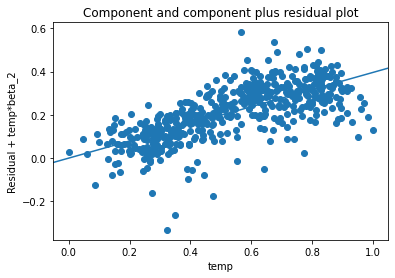

In [453]:
#validating linear relationship
sm.graphics.plot_ccpr(lr_model4, 'temp')
plt.show()

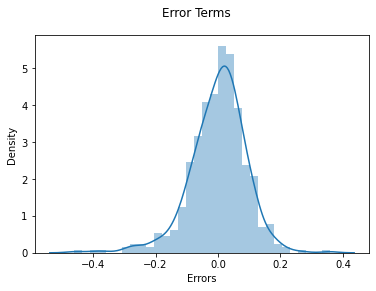

In [454]:
# Normality of Errors
y_train_pred = lr_model4.predict(X_train_sm)
# Ploting the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred))
fig.suptitle('Error Terms')                  
plt.xlabel('Errors')     
plt.show()

In [455]:
#checking the most used durbin watson value 
print('Value:',round(sm.stats.stattools.durbin_watson((y_train - y_train_pred)),4))

Value: 1.9348


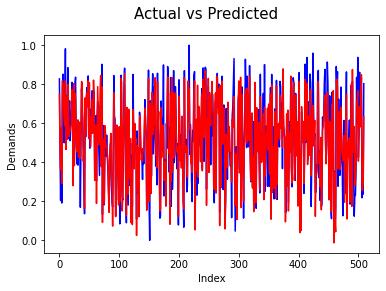

In [456]:
#actual vs predicted
c = [i for i in range(0,len(X_train),1)]
plt.plot(c,y_train, color="blue")
plt.plot(c,y_train_pred, color="red")
plt.suptitle('Actual vs Predicted', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('Demands')
plt.show()

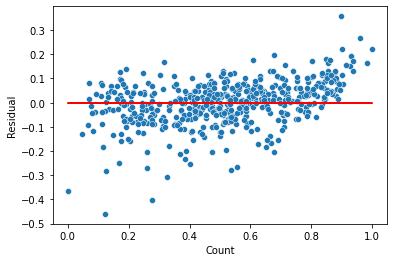

In [457]:
#validating homoscedasticity
y_train_pred = lr_model4.predict(X_train_sm)
sns.scatterplot(y_train,(y_train - y_train_pred))
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()

##### **Observations:**
* The linearity is pefectly alright.
* Error terms are normally distributed.
* Actual vs predicted looks good.
* Homoscedasticity is constant.
* The Durbin-Watson value for final model is 1.9348 which is good.

### **Predictions**

In [458]:
#scaling the test dataset 
cols = df_test.columns
df_test[cols] = scaler.transform(df_test[cols])
#dividing into X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test
#adding the constant 
X_test_m4 = sm.add_constant(X_test)
#considering the final model features only and dropping others
X_test_m4 = X_test_m4.drop(['weathersit_moderate','holiday','workingday','weekday_sat','weekday_sun',
                            'atemp','hum','mnth_aug','mnth_feb','mnth_jun','mnth_mar','mnth_may',
                            'mnth_oct','season_summer'], axis=1)
#prediction using final model
y_test_pred = lr_model4.predict(X_test_m4)

### **Model Evaluatiion**

In [459]:
#checking r2 value for trained data
r2_score(y_train,y_train_pred)

0.8350134748119569

In [460]:
# Find out the R squared value between test and predicted test data sets.  
r2_score(y_test,y_test_pred)

0.819833693001639

##### **Observations:**
* The R2 value of train dataset is 0.835.
* The R2 Value of test dataset is 0.819.
* The tested model is 81.9% accurate and is considered as good model.

### **Conclusion**

* temp is a feature that is most considered by people while opting the bike-sharing service.
* As we only have data of 2years we can conclude that the company has performed better than last year i.e.., the company has performed well in 2019 compared to 2018.
* As the company is aiming to post covid scenario the factors that might influence their market are temp,season,weekend and will have high demand in few months based on weather situation and other factors.
* Post covid market will surely be impacted by sanitization of vehicles which is not included in the past years so this might also be a deciding factor which is to be considered by the comoany in coming future.